In [1]:
# Import libraries

import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import plot_model



import tensorflow_datasets as tfds

In [2]:
# Load the data

p_camelyon, p_camelyon_info = tfds.load("patch_camelyon", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteZ0E2J5/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteZ0E2J5/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteZ0E2J5/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


In [3]:
# Defining a "normalize" function to process the data before feeding it into the deep neural network. 

def normalize(x):
  image, label = x['image'], x['label']
  image = tf.image.convert_image_dtype(image, tf.float32)
  label = tf.one_hot(label, 2, dtype=tf.float32)
  return image, label

In [14]:
# Applying "normalize" function along with others to the data

# Processing the training dataset
train_ds = p_camelyon['train'].map(normalize, num_parallel_calls=8)
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(64)
train_ds = train_ds.prefetch(2)

# Processing validation dataset
validation_ds = p_camelyon['validation'].map(normalize, num_parallel_calls=8)
validation_ds = validation_ds.repeat()
validation_ds = validation_ds.batch(128)
validation_ds = validation_ds.prefetch(2)

#Processing the test dataset
test_ds = p_camelyon['test'].map(normalize, num_parallel_calls=8)
test_ds = test_ds.batch(128)
test_ds = test_ds.prefetch(2)

#Seperating image and label into different variables
train_images, train_labels = next(iter(train_ds))
valid_images, valid_labels = next(iter(validation_ds))
test_images, test_labels  = next(iter(test_ds))



In [13]:
import math

batch_size_for_training = 64
batch_size_for_validation = 128
batch_size_for_test = 128

training_size = 262144
validation_size = 32768
test_size =  32768
        

# Calculate steps for training and testing the model
calculate_steps_training = lambda x: int(math.ceil(1. * x / batch_size_for_training))
calculate_steps_validation = lambda x: int(math.ceil(1. * x / batch_size_for_validation))
calculate_steps_test= lambda x: int(math.ceil(1. * x / batch_size_for_test))

steps_per_epoch = calculate_steps_training(training_size) 
validation_steps = calculate_steps_validation(validation_size)
steps = calculate_steps_test(test_size)

print("Training steps: ", steps_per_epoch)
print("Validation steps: ", validation_steps)
print("Testing steps: ", steps)


Training steps:  4096
Validation steps:  256
Testing steps:  256


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 94, 94, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 47, 47, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 35344)             0         
                                                                 
 dense (Dense)               (None, 256)               9048320   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

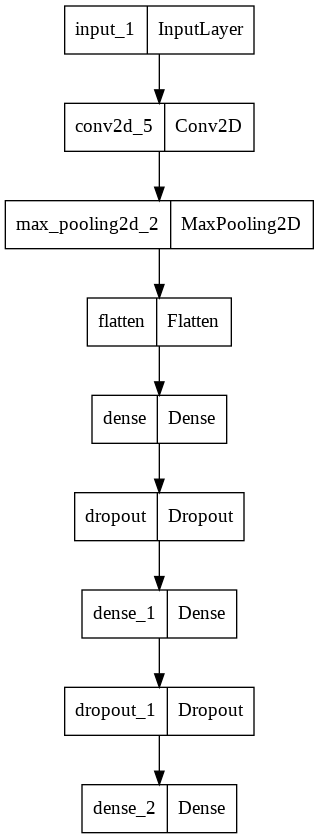

In [6]:
# Building the Convolutonal Neural Network Version 2 Model 1

# Setting up the output with the right size
input = Input(shape=(96,96,3))

# Rely activation functions only, with softmax activation function for the last Dense layer
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='valid')(x)
x = Conv2D(16, (3,3), activation='relu', padding='valid')(input)
x = MaxPool2D(pool_size=(2,2), strides=(2,2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.2)(x)
output = Dense(2, activation='softmax')(x)

# Optimizer = adam
# Loss function = binary_cross_entropy
model_1_version_2 = Model(inputs=input, outputs = output)
model_1_version_2.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['acc'])

model_1_version_2.summary()
plot_model(model_1_version_2)

In [7]:
import matplotlib.pyplot as plt

def plot_hist(history):
  plt.plot(history.history["acc"])
  plt.plot(history.history["val_acc"])
  plt.title("Model Accuracy")
  plt.ylabel("Accuracy")
  plt.xlabel("Epochs")
  plt.legend(["train", "validation"], loc="upper left")
  plt.show()

In [8]:
# Training the model

history_1_version_2= model_1_version_2.fit(train_ds, validation_data=validation_ds, epochs = 10, verbose = 1, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)

Epoch 1/10
4096/4096 [==============================] - 101s 22ms/step - loss: 0.4626 - acc: 0.7883 - val_loss: 0.4709 - val_acc: 0.7763
Epoch 2/10
4096/4096 [==============================] - 82s 20ms/step - loss: 0.3774 - acc: 0.8378 - val_loss: 0.5180 - val_acc: 0.7802
Epoch 3/10
4096/4096 [==============================] - 83s 20ms/step - loss: 0.3211 - acc: 0.8678 - val_loss: 0.5090 - val_acc: 0.7779
Epoch 4/10
4096/4096 [==============================] - 108s 26ms/step - loss: 0.2747 - acc: 0.8907 - val_loss: 0.5958 - val_acc: 0.7643
Epoch 5/10
4096/4096 [==============================] - 85s 21ms/step - loss: 0.2411 - acc: 0.9064 - val_loss: 0.7351 - val_acc: 0.7367
Epoch 6/10
4096/4096 [==============================] - 86s 21ms/step - loss: 0.2152 - acc: 0.9173 - val_loss: 0.7592 - val_acc: 0.7622
Epoch 7/10
4096/4096 [==============================] - 85s 21ms/step - loss: 0.1933 - acc: 0.9265 - val_loss: 0.6936 - val_acc: 0.7484
Epoch 8/10
4096/4096 [========================

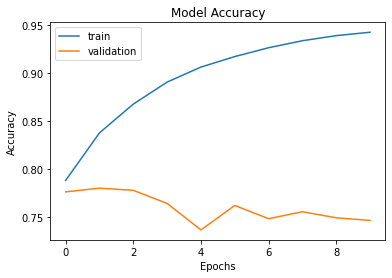

In [9]:
plot_hist(history_1_version_2)

In [10]:
#Testing the model

print("Test dataset accuracy for model 1 version 2 is: {0:.4f}".format(model_1_version_2.evaluate(test_ds, steps=steps, verbose=1)[1]))

256/256 [==============================] - 9s 33ms/step - loss: 0.8771 - acc: 0.7195
Test dataset accuracy for model 1 version 2 is: 0.7195
